# 语义分割和数据集
本节将探讨*语义分割*（semantic segmentation）问题，它重点关注于如何将图像分割成属于不同语义类别的区域。  
与目标检测不同，语义分割可以识别并理解图像中每一个像素的内容：其语义区域的标注和预测是像素级的。与目标检测相比，语义分割标注的像素级的边框显然更加精细。

![语义分割中图像有关狗、猫和背景的标签](../img/segmentation.svg)

## 下载数据集

In [33]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [34]:
#@save
# d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar','4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

# voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
voc_dir = '../data/VOCdevkit/VOC2012'

In [35]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation','train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

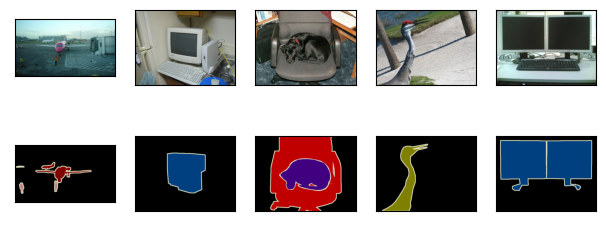

In [36]:
# 绘制前5个输入图像及其标签。在标签图像中，白色和黑色分别表示边框和背景，而其他颜色则对应不同的类别。
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

## 实现从RGB到VOC类别索引的映射

In [37]:
# 列举RGB颜色值和类名
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

假设 colormap 是一个形状为 (H, W, 3) 的张量，其中 H 表示图像的高度，W 表示图像的宽度，3 表示每个像素点有 RGB 三个通道。  
在这种情况下，idx 的形状将是 (H, W)。其中每个元素都是一个整数，表示像素的颜色索引，  
那么 colormap2label[idx] 将返回一个形状也为 (H, W) 的张量，其中每个元素是对应像素的 VOC 类别索引。

In [38]:
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    # 张量的大小为 ( 256^3 )，确保了它可以存储 RGB 颜色空间中所有可能的颜色值的映射关系
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256+ colormap[:, :, 2])
    return colormap2label[idx]

[**例如**]，在第一张样本图像中，飞机头部区域的类别索引为1，而背景索引为0。

In [39]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

## 预处理数据
在之前的实验，如`sec_alexnet`、`sec_googlenet`中，通过再缩放图像使其符合模型的输入形状。  
然而在语义分割中，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。这样的映射可能不够精确，尤其在不同语义的分割区域。  
为了避免这个问题，我们将图像裁剪为固定尺寸，而不是再缩放。  
（缩放可能会对标签图像进行插值，插入的RGB值可能不对应任何一个类）  
具体来说，[**使用图像增广中的随机裁剪，裁剪输入图像和标签的相同区域**]。

**torchvision.transforms.RandomCrop.get_params(feature, (height, width))**:使用PyTorch的RandomCrop变换的get_params 方法来生成裁剪的参数rect。  
**torchvision.transforms.RandomCrop.get_params**:返回一个裁剪的起始位置参数 (top, left, height, width)，而不是一个裁剪后的图像。

In [40]:
#@save
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

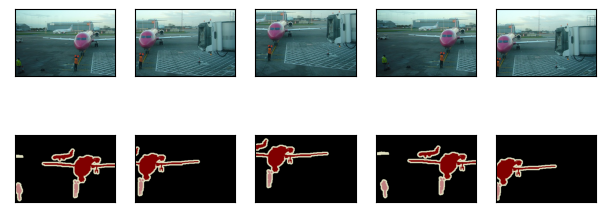

In [41]:
# [::2] 的作用是从列表中的第1个元素（索引为0）开始，每隔一个元素取一个，直到列表末尾，即取出索引为偶数的元素
# [1::2] 的作用是从列表中的第二个元素（索引为1）开始，每隔一个元素取一个，直到列表末尾，即取出索引为奇数的元素
# +：列表的连接操作
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

## 自定义语义分割数据集类

通过继承高级API提供的`Dataset`类，自定义了一个语义分割数据集类`VOCSegDataset`。  
通过实现`__getitem__`函数，可以任意访问数据集中索引为`idx`的输入图像及其每个像素的类别索引。  
由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本可以通过自定义的`filter`函数移除掉。  
此外，还定义了`normalize_image`函数，从而对输入图像的RGB三个通道的值分别做标准化。  

In [49]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

## 读取数据集
创建训练集和测试集的实例。假设指定随机裁剪的输出图像的形状为 320×480。

In [50]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


设批量大小为64，我们定义训练集的迭代器。
打印第一个小批量的形状会发现：与图像分类或目标检测不同，这里的标签是一个三维数组。  
图像分类：（1）整数：1维，n为样本数（2）独热编码：2维（n*c），样本数+类别数  
目标检测：5维，类别+边界框坐标  
语义分割：3维，批量数+图片高宽  

In [ ]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,drop_last=True,num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

## 整合所有组件

In [ ]:
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
#     voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    voc_dir = '../data/VOCdevkit/VOC2012'
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter